<a href="https://colab.research.google.com/github/Alx-Lebeau/Cours-EcoElec/blob/main/equilibre_court_terme.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/Alx-Lebeau/Cours-EcoElec.git
%cd Cours-EcoElec/notebooks
!ls

import pandas as pd
import matplotlib.pyplot as plt
import pulp as pl


Cloning into 'Cours-EcoElec'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 15 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (15/15), 228.23 KiB | 5.71 MiB/s, done.
/content/Cours-EcoElec/Cours-EcoElec/Cours-EcoElec/Cours-EcoElec/notebooks/Cours-EcoElec/notebooks/Cours-EcoElec/notebooks
Consommation_France_2024.csv  Equilibre_Court_Terme.ipynb


# Import des données

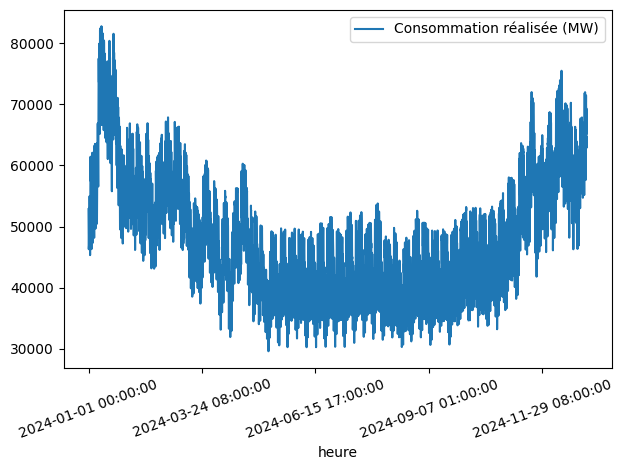

In [ ]:
df = pd.read_csv("Consommation_France_2024.csv")

df.plot(x="heure",y="Consommation réalisée (MW)")

plt.xticks(rotation=20)
plt.tight_layout()


# Premier modèle

## Données d'entrée

In [ ]:


# ---- Données d'entrée ----
# Générateurs : coût variable et capacité maximale (MW)
generateurs = {
    "charbon": {"cout_var": 20.0, "capacite": 100.0},
    "gaz":     {"cout_var": 50.0, "capacite": 80.0},
    "fioul":   {"cout_var": 80.0, "capacite": 50.0},
}

# Demande (MW) à chaque pas de temps

demande = [120.0, 130.0, 110.0, 90.0]


## Ecriture du modèle
### Initialisation

In [ ]:
# ---- Ensembles ----
techs = list(generateurs.keys())
T = range(len(demande))

# ---- Modèle ----
modele = pl.LpProblem("Dispatch_Electrique_Court_Terme", pl.LpMinimize)



### Définition des variables décision

In [ ]:
# ---- Variables de décision ----
# prod[g, t] = production de la technologie g au temps t (MW)
prod = pl.LpVariable.dicts("prod", (techs, T), lowBound=0)



### Définition de l'objectif

In [ ]:
# ---- Objectif : minimiser le coût total ----
modele += pl.lpSum(
    prod[g][t] * generateurs[g]["cout_var"]
    for g in techs for t in T
)



### Définition des contrainte

In [ ]:
# ---- Contraintes ----

# 1) Équilibre offre = demande à chaque pas de temps
for t in T:
    modele += pl.lpSum(prod[g][t] for g in techs) == demande[t], f"Equilibre_t{t}"

# 2) Limite de capacité de chaque centrale
for g in techs:
    cap = generateurs[g]["capacite"]
    for t in T:
        modele += prod[g][t] <= cap, f"Capacite_{g}_t{t}"



### Résolution et affichage des résultats

In [ ]:
# ---- Résolution ----
modele.solve(pl.PULP_CBC_CMD(msg=False))

print("Statut :", pl.LpStatus[modele.status])
print("Coût total :", pl.value(modele.objective))

# ---- Affichage des résultats ----
for g in techs:
    print(f"\nProduction de {g} :")
    for t in T:
        print(f"  t={t} : {prod[g][t].value():6.2f} MW")


Statut : Optimal
Coût total : 10800.0

Production de charbon :
  t=0 : 100.00 MW
  t=1 : 100.00 MW
  t=2 : 100.00 MW
  t=3 :  90.00 MW

Production de gaz :
  t=0 :  20.00 MW
  t=1 :  30.00 MW
  t=2 :  10.00 MW
  t=3 :   0.00 MW

Production de fioul :
  t=0 :   0.00 MW
  t=1 :   0.00 MW
  t=2 :   0.00 MW
  t=3 :   0.00 MW
